In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "syllables_02_sc", "std_phon_trace", 'spectral_centroid']
INTERESTING_TRACES += [f"syllables_{i}_ts" for i in range(7)]

## Save folder for long-run estimators
ESTIMATORS_FOLDER = os.path.join("..", "estimators")
# matplotlib.rcParams['figure.figsize'] = (10, 5)

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import default_style

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import

In [33]:
df = pd.read_csv(DF_PREPROC_FILE)
df.drop(columns=["fourier_coeffs", "path", "filtered_fourier_coeffs"], inplace=True)

categorical_attributes = [col for col in df.columns if not is_numeric_dtype(df[col])]


traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)

# print(traces["syll_labels"].shape)

## Metrics

In [34]:
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

In [35]:
mat_euclidean = cdist(np.stack(traces["std_phon_trace"])[:10],np.stack(traces["std_phon_trace"])[:10])

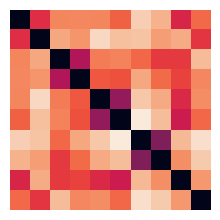

In [36]:
plt.grid("")
plt.axis("off")
plt.imshow(mat_euclidean)

Text(0.5, 0, 'Euclidean distance')

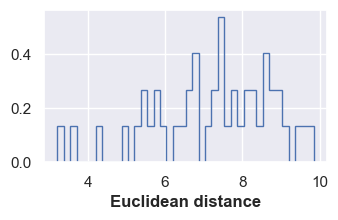

In [37]:
# Distribution of distances
distances_eucl = np.triu(mat_euclidean).reshape(-1)
distances_eucl = distances_eucl[distances_eucl != 0.0]
plt.hist(distances_eucl, histtype="step", bins=40, density=True);
plt.xlabel("Euclidean distance")

### Manhattan

In [38]:
mat_manhattan = cdist(np.stack(traces["std_phon_trace"]),np.stack(traces["std_phon_trace"]), metric="cityblock")

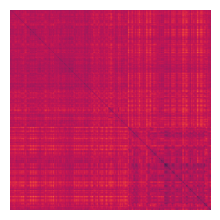

In [39]:
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

plt.grid("")
plt.axis("off")
plt.imshow(mat_manhattan)

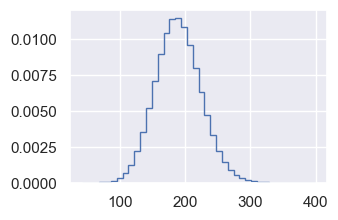

In [40]:
# Distribution of distances
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

distances_man = np.triu(mat_manhattan).reshape(-1)
distances_man = distances_man[distances_man != 0.0]
plt.hist(distances_man, histtype="step", bins=40, density=True);

### DTW

In [41]:
from tslearn.metrics import cdist_dtw

mat_dtw = cdist_dtw(np.stack(traces["std_phon_trace"])[:10],np.stack(traces["std_phon_trace"])[:10], itakura_max_slope=2, n_jobs=-1)

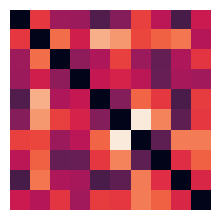

In [42]:
fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)

plt.grid("")
plt.axis("off")
plt.imshow(mat_dtw)

## Kmeans

### Std phonetic (Euclidean)

In [43]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score, KernelKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, adjusted_mutual_info_score as ami

In [44]:
X = np.stack(np.stack(traces["std_phon_trace"]))
print(np.stack(traces["std_phon_trace"]).shape)
print(X.shape)

(2452, 700)
(2452, 700)


C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.20241228480410073, 0.02674713034164326, 0.009658836921921614, 0.015498187257063627, -5.67615175483098e-05, 0.01353232960152745, -0.00019190534794109138]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.17548624519417189, 0.031360765616086625, 0.020042530665884475, 0.05967523656869749, -0.0002685630253284843, 0.021722191466461732, -7.367001673765249e-05]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.16465310305207342, 0.03065164740694692, 0.0191393749697141, 0.062168457894269696, -0.00023889006660910567, 0.03359480118820466, 5.630147217198474e-05]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.16459643493201964, 0.03762400955674513, 0.0173999311176469, 0.0626298339913304, -0.00037911375885712806, 0.04414473662874959, 0.00040716622317411963]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.1696188108213313, 0.041584245392368796, 0.018078152695697715, 0.06599436348066015, -0.00021879952900249333, 0.03972787674166412, 0.0036423482451404857]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.1622705412841248, 0.05014900856837362, 0.022786881675557293, 0.04977242821491022, -0.00044556908853211273, 0.0505503685590457, 0.002175897829688112]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.16013138406903668, 0.050148496968068786, 0.021068582751834323, 0.061121929744093494, -0.0006727952505063236, 0.054431369596902854, 0.0036873965851953222]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.16027115069148049, 0.04890583525633159, 0.017969886700922803, 0.06346951504966816, -0.0006705853407259403, 0.05742044982554167, 0.003931423361643324]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.15992546005263508, 0.05786589331755615, 0.019946660202574084, 0.05158818536078858, -0.00013216149741844283, 0.07309072951856674, 0.005734776446061245]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.17972387795070852, 0.049937630720006496, 0.01663594471996362, 0.0637938646266113, -0.0006477138457022364, 0.07403592909662238, 0.005407657836116934]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.1541367507607811, 0.055873059812266965, 0.019008708344769868, 0.07021354774559499, -0.0005554611327601592, 0.07080150683330627, 0.006286361179081225]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.17001010507674624, 0.048432368112484074, 0.01574805502181053, 0.08882602166696849, -0.000227155140122226, 0.07524829837113949, 0.005991637064784787]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.15401105994595884, 0.04738518751590626, 0.01862625775244738, 0.07668272001691892, -0.00022760184637887786, 0.08479373767100448, 0.005307748064072887]



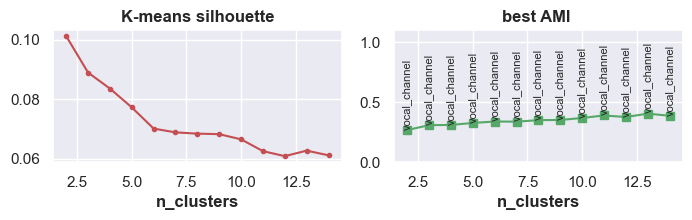

In [45]:
fig, axes = plt.subplot_mosaic([["sil", "ami"]], 
                              width_ratios=[1,  1],  
                              figsize=default_style.SHORT_FULLSIZE_FIGURE)

sil_scores = []
amis = []
ns_clust = np.arange(2, 15)

for n in ns_clust:
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", n_jobs=-1)
    km.fit(X)
    predictions = km.predict(X)
    sil_scores.append(silhouette_score(X, predictions, metric="euclidean", n_jobs=-1))
    
    ami_list = [ami(predictions, df[cat]) for cat in categorical_attributes]
    print(categorical_attributes)
    print(ami_list)
    print()
    amis.append(np.sum(ami_list))
    axes['ami'].annotate(f"{categorical_attributes[np.argmax(ami_list)]}",xy=(n, amis[-1]+0.02), ha="center", rotation=90, size=8)
    
axes["sil"].plot(ns_clust, sil_scores, label="silhouette", marker=".", color="r")
axes["ami"].plot(ns_clust, amis, label="sum AMI", marker="s", color="g")
axes["sil"].set_title('K-means silhouette')
axes["sil"].set_xlabel('n_clusters')
axes["ami"].set_title('best AMI ')
axes["ami"].set_xlabel('n_clusters')
axes['ami'].set_ylim(0, 1.1)
# axes['ami'].legend(loc="center", bbox_to_anchor=(0.6, 0.3))
fig.savefig("../images/ts_cluster_ami_sil_phon.pdf")

In [46]:
n_clusters = 6

km = TimeSeriesKMeans(n_clusters=n_clusters,
                      metric="euclidean",
                      verbose=False, 
                      n_jobs=-1)
km.fit_predict(X)

# fig, axes = plt.subplots(n_clusters,1,sharex=True, figsize=default_style.SHORT_FULLSIZE_FIGURE)

# for clus in range(n_clusters):
#     cluster_elements = X[km.labels_ == clus]
#     for i in range(5):
#         axes[clus].plot(cluster_elements[i], alpha=0.4, color="k")
#     axes[clus].set_yticks([])
#     axes[clus].plot(km.cluster_centers_[clus])
    
# df_ami = pd.DataFrame(columns=categorical_attributes)
# for cat in categorical_attributes:
#     print(cat, ami(km.labels_, df[cat]))
# plt.savefig("../images/ts_classification.pdf")

array([5, 5, 3, ..., 5, 1, 1], dtype=int64)

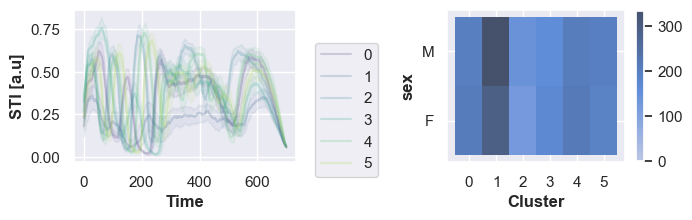

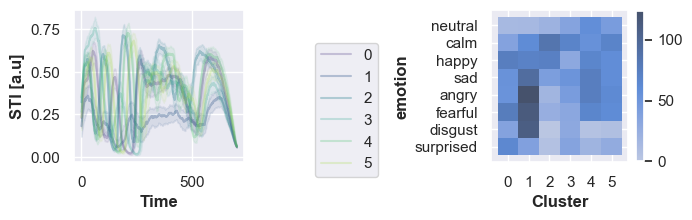

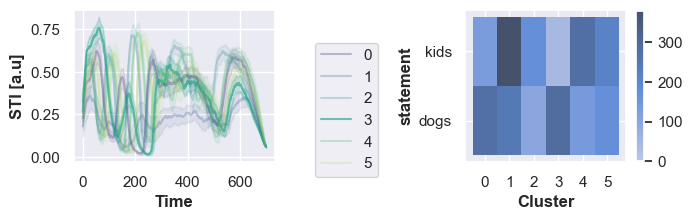

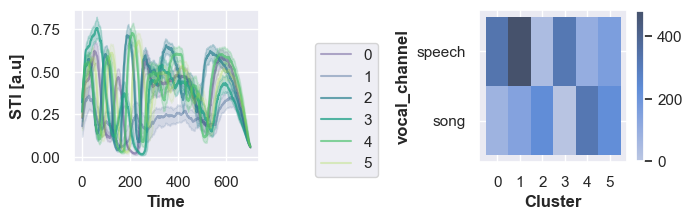

In [47]:
category = ['sex', 'emotion', 'statement', 'vocal_channel']

for cat in category:
    fig, axes = plt.subplot_mosaic([["t", "leg", "hist"]], 
                                  width_ratios=[1, 0.1, 1],  
                                  figsize=default_style.SHORT_FULLSIZE_FIGURE)

    colors=sns.color_palette("viridis", n_colors=n_clusters)

    for i in range(n_clusters):
        cluster_traces = np.where(km.labels_ == i)[0]

        alpha = min(5*np.abs(ami(km.labels_ == i, df[cat])) + 0.2, 1)

        low, mid, up = np.quantile(X[cluster_traces], [0.4, 0.5, 0.6], axis=0)
        axes["t"].plot(mid, color=colors[i], label=f"{i}", alpha=alpha)
        axes["t"].fill_between(np.arange(X.shape[1]),low, up, alpha=alpha/3, color=colors[i])

    sns.histplot(x=km.labels_.astype(int),bins=( list(np.arange(n_clusters+1) -0.01) ), 
                 y=df[cat],
                 cbar=True, cbar_kws=dict(shrink=.99))
    axes["hist"].set_xticks(np.arange(n_clusters)+0.5, labels=range(n_clusters));

    axes["t"].set_ylabel("STI [a.u]");
    axes["t"].set_xlabel("Time")
    fig.legend(loc="center", title="")

    axes["hist"].set_xlabel("Cluster")

    axes["leg"].axis("off")

    fig.savefig(f"../images/ts_cluster_counts_phon{cat}.pdf")

In [48]:
from sklearn.decomposition import PCA

In [49]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

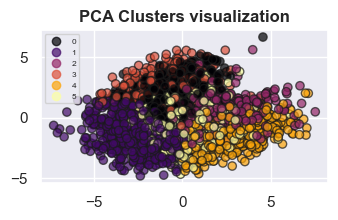

In [50]:
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap='inferno', edgecolor='k'
             , alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(km.labels_)),fontsize="6")
plt.title('PCA Clusters visualization')
plt.savefig(f"../images/ts_cluster_pca_phon.pdf")
plt.show()

### Syllable_02 timeseries (euclidean)

In [51]:
X = traces["spectral_centroid"]
print(traces["spectral_centroid"].shape)
print(X.shape)

(2452, 54)
(2452, 54)


C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.02640842459574272, 0.02897477993696401, 0.03138132828490083, 0.0027448083499600484, -0.00013103305007375744, 0.11559993485757282, 0.2459052695375134]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.021909901509013435, 0.05387721160364202, 0.038778342208819136, 0.0009410097837529833, -0.00038763121206635877, 0.11894160853642859, 0.1964903737099191]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.027770969247807177, 0.05561274237195654, 0.030632391578662918, 0.1371356411080398, -0.0004422046669790814, 0.10771003680965556, 0.15143944815445015]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.044387487448793304, 0.052204879323844926, 0.02255718855184494, 0.1456366617451139, -0.000634158502772836, 0.12670893238444286, 0.1677856500130513]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.07059460452836497, 0.05633457779112912, 0.023174853859354888, 0.1172084798775507, -0.000479501210245442, 0.1391757026947807, 0.17685392100148598]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.07451591088675391, 0.05391829304511423, 0.02182605280209368, 0.16691818574462178, -0.0006248156936454585, 0.13498601458378987, 0.15642745166377203]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08785906035349961, 0.06122190882624882, 0.022160847870185726, 0.1662908230244243, -0.0006013869182706426, 0.1346509084163187, 0.14068177422451322]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.06799193835889922, 0.05757935232588627, 0.020824543501349838, 0.1390002196868395, -0.0006182374874524263, 0.14404227971994674, 0.1524274322221003]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.0745268142503927, 0.05709341685067425, 0.021239664299148836, 0.17151514306302856, -0.0005203563291598593, 0.14597177230269762, 0.1491795439920146]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.07679955536143841, 0.059033836061477024, 0.0214068049945654, 0.14460797197924657, -0.0008624270525076234, 0.15189556935017073, 0.14346926984817718]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.0797378928675462, 0.06460227526662367, 0.022566051122946695, 0.16306864765060136, -0.0010000251122143065, 0.15447152300547548, 0.1316796057281383]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08301562174601824, 0.05859466989073315, 0.023191665137541787, 0.12628536317189404, -0.0005780524482745826, 0.15207680189133904, 0.13057743324653567]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08348509390905016, 0.06295452253514044, 0.025499851553089904, 0.15988256229654776, -0.0006737400722618486, 0.149029682060433, 0.13701858716181609]



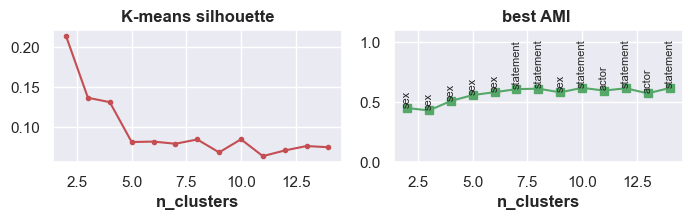

In [52]:
fig, axes = plt.subplot_mosaic([["sil", "ami"]], 
                              width_ratios=[1,  1],  
                              figsize=default_style.SHORT_FULLSIZE_FIGURE)

sil_scores = []
amis = []
ns_clust = np.arange(2, 15)

for n in ns_clust:
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", n_jobs=-1)
    km.fit(X)
    predictions = km.predict(X)
    sil_scores.append(silhouette_score(X, predictions, metric="euclidean", n_jobs=-1))
    
    ami_list = [ami(predictions, df[cat]) for cat in categorical_attributes]
    print(categorical_attributes)
    print(ami_list)
    print()
    amis.append(np.sum(ami_list))
    axes['ami'].annotate(f"{categorical_attributes[np.argmax(ami_list)]}",xy=(n, amis[-1]+0.02), ha="center", rotation=90, size=8)
    
axes["sil"].plot(ns_clust, sil_scores, label="silhouette", marker=".", color="r")
axes["ami"].plot(ns_clust, amis, label="sum AMI", marker="s", color="g")
axes["sil"].set_title('K-means silhouette')
axes["sil"].set_xlabel('n_clusters')
axes["ami"].set_title('best AMI ')
axes["ami"].set_xlabel('n_clusters')
axes['ami'].set_ylim(0, 1.1)
# axes['ami'].legend(loc="center", bbox_to_anchor=(0.6, 0.3))
fig.savefig("../images/ts_cluster_ami_sil_syll.pdf")

In [53]:
n_clusters = 5

km = TimeSeriesKMeans(n_clusters=n_clusters,
                      metric="euclidean",
                      verbose=False, 
                      n_jobs=-1)
km.fit_predict(X)

array([2, 2, 2, ..., 0, 4, 4], dtype=int64)

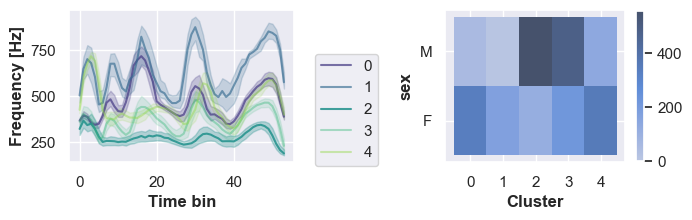

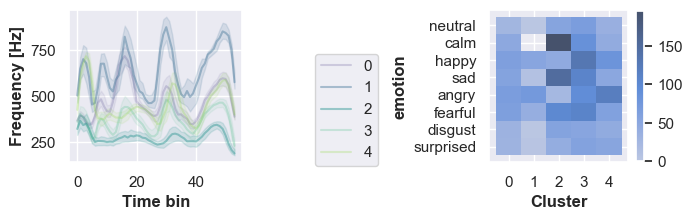

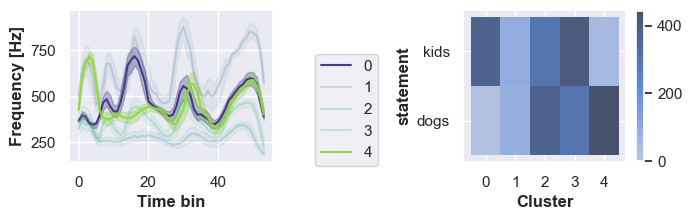

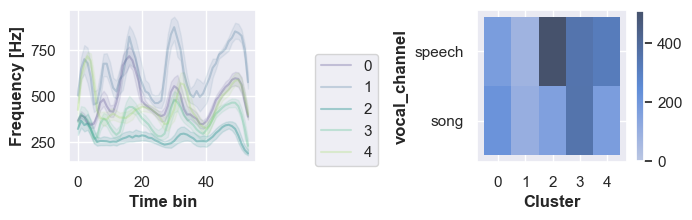

In [54]:
category = ['sex', 'emotion', 'statement', 'vocal_channel']

for cat in category:
    fig, axes = plt.subplot_mosaic([["t", "leg", "hist"]], 
                                  width_ratios=[1, 0.1, 1],  
                                  figsize=default_style.SHORT_FULLSIZE_FIGURE)

    colors=sns.color_palette("viridis", n_colors=n_clusters)

    for i in range(n_clusters):
        cluster_traces = np.where(km.labels_ == i)[0]

        alpha = min(5*np.abs(ami(km.labels_ == i, df[cat])) + 0.2, 1)

        low, mid, up = np.quantile(X[cluster_traces], [0.4, 0.5, 0.6], axis=0)
        axes["t"].plot(mid, color=colors[i], label=f"{i}", alpha=alpha)
        axes["t"].fill_between(np.arange(X.shape[1]),low, up, alpha=alpha/3, color=colors[i])

    sns.histplot(x=km.labels_.astype(int),bins=( list(np.arange(n_clusters+1) -0.01) ), 
                 y=df[cat],
                 cbar=True, cbar_kws=dict(shrink=.99))
    axes["hist"].set_xticks(np.arange(n_clusters)+0.5, labels=range(n_clusters));

    axes["t"].set_ylabel("Frequency [Hz]");
    axes["t"].set_xlabel("Time bin")
    fig.legend(loc="center", title="")

    axes["hist"].set_xlabel("Cluster")

    axes["leg"].axis("off")

    fig.savefig(f"../images/ts_cluster_counts_syll{cat}.pdf")

In [55]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

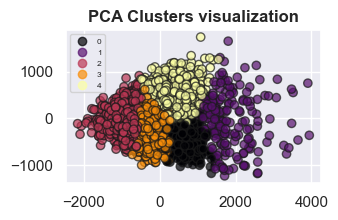

In [56]:
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap='inferno', edgecolor='k'
             , alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(km.labels_)),fontsize="6")
plt.title('PCA Clusters visualization')
plt.savefig(f"../images/ts_cluster_pca_syll.pdf")
plt.show()

## Features clustering 

## phonetic

In [57]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

In [58]:
X = np.stack(traces['std_phon_trace'])


In [59]:
def calculate_features(values):
    peaks = find_peaks(values, distance=3, prominence=[0.20,10])
    features = {
        'peaks':len(peaks[0]),
        'min': np.min(values),
        'max': np.max(values),
        'avg': np.mean(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '80p': np.percentile(values, 80),
        
    }

    return features

In [60]:
F = [list(calculate_features(x).values()) for x in X]

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.18799527361912313, 0.026466369325847127, 0.010724597419899829, 0.012309503615216752, 0.0002442003477687321, 0.01414565525982195, -0.0002692411715107069]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.17481815337912904, 0.031105966415974174, 0.019594998721428267, 0.05886283621556681, -0.0003279275954448398, 0.021235048091823996, -7.541517882187474e-05]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.1647830497342803, 0.03295450469186894, 0.018457651625977775, 0.06073768310287146, -0.0004772225428064793, 0.03488065477113519, -3.1851017818170005e-05]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.17247759728113665, 0.03414401584095897, 0.016994669194354207, 0.06540626728983658, -0.00046110214314234375, 0.035343895357744716, 0.0010596936532594322]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.15175545884682934, 0.04480911854979095, 0.018741641374276193, 0.050465469459149606, -0.00024302016131873044, 0.04549879397979679, 0.0009277713528729207]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.1641161796246574, 0.04362456793786672, 0.015531309199308825, 0.06570021738459243, -0.000608521472435807, 0.04948798820805326, 0.003599048784080094]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.15270827404837947, 0.044429302598204726, 0.017890855259470886, 0.06909398111203578, -0.0006302243711931956, 0.05106836125630861, -0.0007054360690955195]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.1597356523486478, 0.047751678682892505, 0.01770294419281015, 0.05472969399314447, -0.00046267343657253483, 0.061756454549551934, 0.0027681459259829965]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.15389491574317332, 0.05543907283822481, 0.01856375907544778, 0.0546355822928672, -0.0005557830710035746, 0.06773127864968409, 0.004000346346868491]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.14671050286906911, 0.053846097251644194, 0.02168513786089173, 0.059381747584310106, -0.0002277800840830676, 0.06580533601316325, 0.004148037951146038]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.16833606104774956, 0.05526234691386478, 0.021658416790705536, 0.07132551025979575, -0.0006005315977530658, 0.07554094092526698, 0.007980649953490966]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.15729211379320127, 0.05155035894471172, 0.01782648734447044, 0.06050502679149103, 0.00015472850872407708, 0.0721334727514192, 0.006258074986024255]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.17456473299715586, 0.05519448318368895, 0.018800942309598116, 0.05783248949389905, -0.0004301760858488392, 0.08185699270236224, 0.008834265246390078]



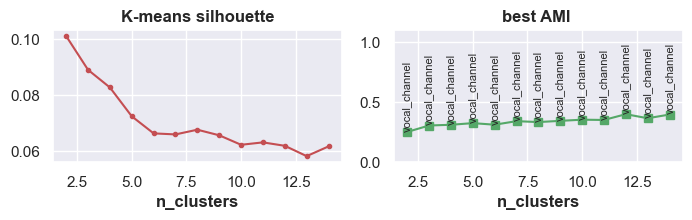

In [61]:
fig, axes = plt.subplot_mosaic([["sil", "ami"]], 
                              width_ratios=[1,  1],  
                              figsize=default_style.SHORT_FULLSIZE_FIGURE)

sil_scores = []
amis = []
ns_clust = np.arange(2, 15)

for n in ns_clust:
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", n_jobs=-1)
    km.fit(X)
    predictions = km.predict(X)
    sil_scores.append(silhouette_score(X, predictions, metric="euclidean", n_jobs=-1))
    
    ami_list = [ami(predictions, df[cat]) for cat in categorical_attributes]
    print(categorical_attributes)
    print(ami_list)
    print()
    amis.append(np.sum(ami_list))
    axes['ami'].annotate(f"{categorical_attributes[np.argmax(ami_list)]}",xy=(n, amis[-1]+0.02), ha="center", rotation=90, size=8)
    
axes["sil"].plot(ns_clust, sil_scores, label="silhouette", marker=".", color="r")
axes["ami"].plot(ns_clust, amis, label="sum AMI", marker="s", color="g")
axes["sil"].set_title('K-means silhouette')
axes["sil"].set_xlabel('n_clusters')
axes["ami"].set_title('best AMI ')
axes["ami"].set_xlabel('n_clusters')
axes['ami'].set_ylim(0, 1.1)
# axes['ami'].legend(loc="center", bbox_to_anchor=(0.6, 0.3))
fig.savefig("../images/ts_features_ami_sil_phon.pdf")

In [62]:
n_clusters = 5


km = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100)
km.fit(F)



KMeans(max_iter=100, n_clusters=5, n_init=10)

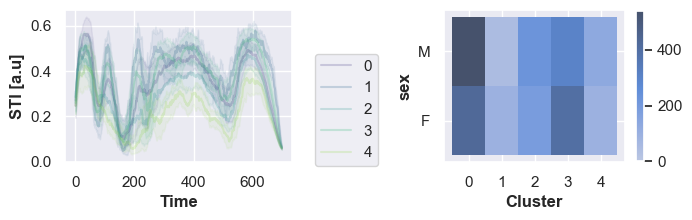

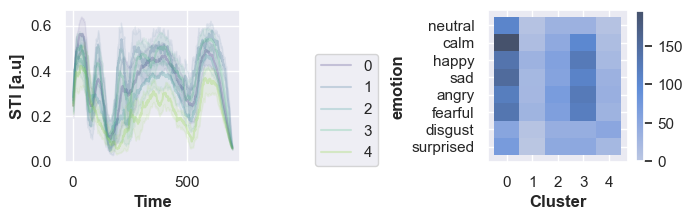

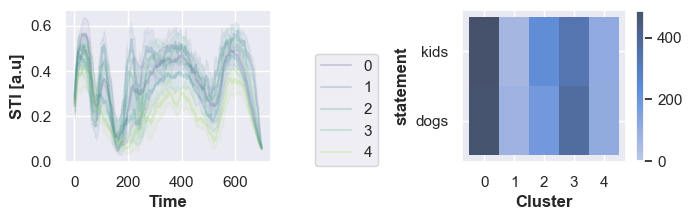

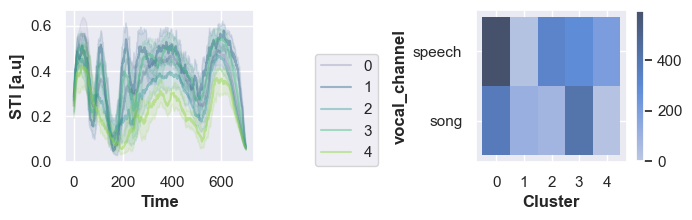

In [63]:
category = ['sex', 'emotion', 'statement', 'vocal_channel']

for cat in category:
    fig, axes = plt.subplot_mosaic([["t", "leg", "hist"]], 
                                  width_ratios=[1, 0.1, 1],  
                                  figsize=default_style.SHORT_FULLSIZE_FIGURE)

    colors=sns.color_palette("viridis", n_colors=n_clusters)

    for i in range(n_clusters):
        cluster_traces = np.where(km.labels_ == i)[0]

        alpha = min(5*np.abs(ami(km.labels_ == i, df[cat])) + 0.2, 1)

        low, mid, up = np.quantile(X[cluster_traces], [0.4, 0.5, 0.6], axis=0)
        axes["t"].plot(mid, color=colors[i], label=f"{i}", alpha=alpha)
        axes["t"].fill_between(np.arange(X.shape[1]),low, up, alpha=alpha/3, color=colors[i])

    sns.histplot(x=km.labels_.astype(int),bins=( list(np.arange(n_clusters+1) -0.01) ), 
                 y=df[cat],
                 cbar=True, cbar_kws=dict(shrink=.99))
    axes["hist"].set_xticks(np.arange(n_clusters)+0.5, labels=range(n_clusters));

    axes["t"].set_ylabel("STI [a.u]");
    axes["t"].set_xlabel("Time")
    fig.legend(loc="center", title="")

    axes["hist"].set_xlabel("Cluster")

    axes["leg"].axis("off")

    fig.savefig(f"../images/ts_features_counts_phon{cat}.pdf")

In [64]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

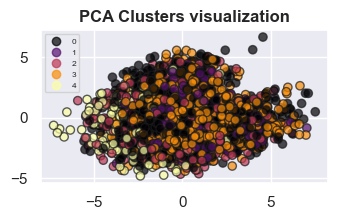

In [65]:
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap='inferno', edgecolor='k'
             , alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(km.labels_)),fontsize="6")
plt.title('PCA Clusters visualization')
plt.savefig(f"../images/ts_features_pca_phon.pdf")
plt.show()

## Syllables_02

In [66]:
X = np.stack(traces['spectral_centroid'])

In [67]:
F = [list(calculate_features(x).values()) for x in X]

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.02640842459574272, 0.028974779936964012, 0.03138132828490083, 0.0027448083499600493, -0.00013103305007375687, 0.11559993485757283, 0.2459052695375134]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.020371056397650467, 0.054214103677265875, 0.037667688454755474, 0.001196723477901059, -0.00040255219967098713, 0.12042673747438362, 0.20316211956107735]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.03015456136404613, 0.05726909215059534, 0.02976794250662748, 0.12907871492042045, -0.00027383522359282546, 0.10890197295647853, 0.15124433092445466]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.029147930480202616, 0.058169117315173595, 0.026520423311123344, 0.12274937960028295, -0.0006496631421035838, 0.12431493609995499, 0.15583911800929143]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.06961931257701613, 0.0623612247460321, 0.023986951828173616, 0.11680581547021585, -0.00041432319856115425, 0.12699885892237656, 0.13885801816161186]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.061880550576027836, 0.05323993595764293, 0.024078583813581106, 0.1655485503458405, -0.0008281716414405002, 0.14826368320474037, 0.1725378710603455]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.07540299961113928, 0.06192002265543623, 0.023354337828656535, 0.15656757650721964, -0.0006818011615107675, 0.1302765686591452, 0.13141710390312075]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.07993255377909667, 0.058528733169415745, 0.024679904695218056, 0.15367840355300788, -0.0010474057982042277, 0.1511747704309975, 0.1471202202285635]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08588191237463284, 0.059364678095867596, 0.020695616690004227, 0.1579466707248517, -0.0008259071109686536, 0.1516841443951651, 0.1446853384057483]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.09139207882059723, 0.06480927235701224, 0.02367163641112241, 0.15360705893219717, -0.0006068219072820395, 0.1476207336464066, 0.14546437769201767]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08283787005976853, 0.057262667922758005, 0.019546711099770343, 0.1773990451114969, -0.000807577899129902, 0.15586778847747906, 0.14064369341237684]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.08804564942580079, 0.06596973255832521, 0.020973934650576526, 0.1545093276311901, -0.001082196797774895, 0.15080324877233328, 0.13171862782206858]



C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2452 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 'sex']
[0.0811326893340988, 0.06610981926212478, 0.02440613223840251, 0.17054172610954257, -0.0008895835018675227, 0.15681380904558165, 0.1309587908772127]



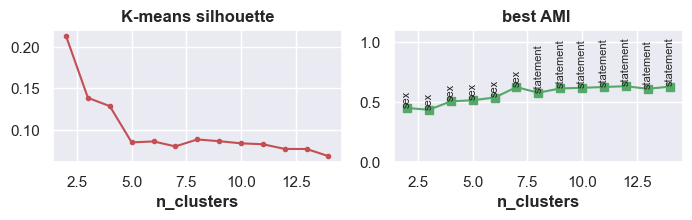

In [68]:
fig, axes = plt.subplot_mosaic([["sil", "ami"]], 
                              width_ratios=[1,  1],  
                              figsize=default_style.SHORT_FULLSIZE_FIGURE)

sil_scores = []
amis = []
ns_clust = np.arange(2, 15)

for n in ns_clust:
    km = TimeSeriesKMeans(n_clusters=n, metric="euclidean", n_jobs=-1)
    km.fit(X)
    predictions = km.predict(X)
    sil_scores.append(silhouette_score(X, predictions, metric="euclidean", n_jobs=-1))
    
    ami_list = [ami(predictions, df[cat]) for cat in categorical_attributes]
    print(categorical_attributes)
    print(ami_list)
    print()
    amis.append(np.sum(ami_list))
    axes['ami'].annotate(f"{categorical_attributes[np.argmax(ami_list)]}",xy=(n, amis[-1]+0.02), ha="center", rotation=90, size=8)
    
axes["sil"].plot(ns_clust, sil_scores, label="silhouette", marker=".", color="r")
axes["ami"].plot(ns_clust, amis, label="sum AMI", marker="s", color="g")
axes["sil"].set_title('K-means silhouette')
axes["sil"].set_xlabel('n_clusters')
axes["ami"].set_title('best AMI ')
axes["ami"].set_xlabel('n_clusters')
axes['ami'].set_ylim(0, 1.1)
# axes['ami'].legend(loc="center", bbox_to_anchor=(0.6, 0.3))
fig.savefig("../images/ts_features_ami_sil_syll.pdf")

In [69]:
n_clusters = 5


km = KMeans(n_clusters=n_clusters, n_init=10, max_iter=100)
km.fit(F)

KMeans(max_iter=100, n_clusters=5, n_init=10)

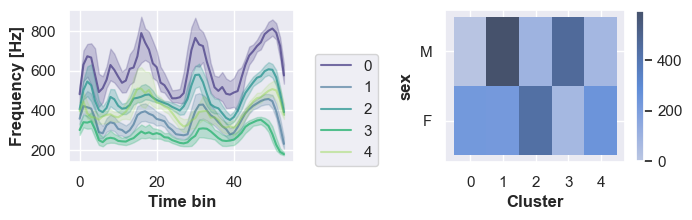

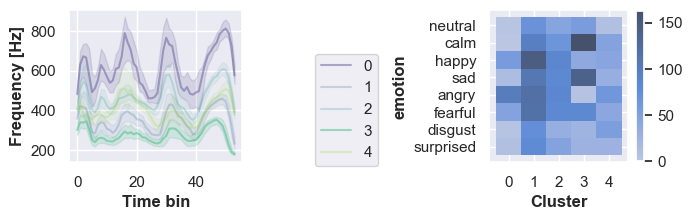

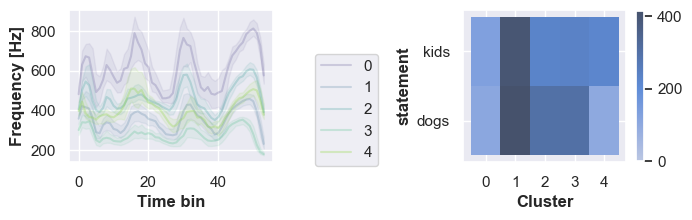

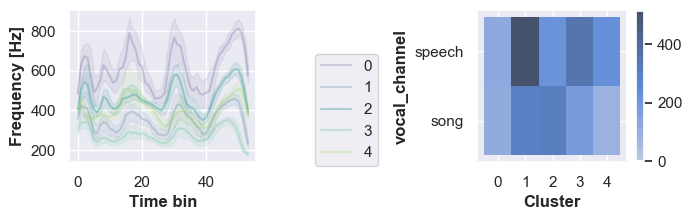

In [70]:
category = ['sex', 'emotion', 'statement', 'vocal_channel']

for cat in category:
    fig, axes = plt.subplot_mosaic([["t", "leg", "hist"]], 
                                  width_ratios=[1, 0.1, 1],  
                                  figsize=default_style.SHORT_FULLSIZE_FIGURE)

    colors=sns.color_palette("viridis", n_colors=n_clusters)

    for i in range(n_clusters):
        cluster_traces = np.where(km.labels_ == i)[0]

        alpha = min(5*np.abs(ami(km.labels_ == i, df[cat])) + 0.2, 1)

        low, mid, up = np.quantile(X[cluster_traces], [0.4, 0.5, 0.6], axis=0)
        axes["t"].plot(mid, color=colors[i], label=f"{i}", alpha=alpha)
        axes["t"].fill_between(np.arange(X.shape[1]),low, up, alpha=alpha/3, color=colors[i])

    sns.histplot(x=km.labels_.astype(int),bins=( list(np.arange(n_clusters+1) -0.01) ), 
                 y=df[cat],
                 cbar=True, cbar_kws=dict(shrink=.99))
    axes["hist"].set_xticks(np.arange(n_clusters)+0.5, labels=range(n_clusters));

    axes["t"].set_ylabel("Frequency [Hz]");
    axes["t"].set_xlabel("Time bin")
    fig.legend(loc="center", title="")

    axes["hist"].set_xlabel("Cluster")

    axes["leg"].axis("off")

    fig.savefig(f"../images/ts_features_counts_syll{cat}.pdf")

In [71]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

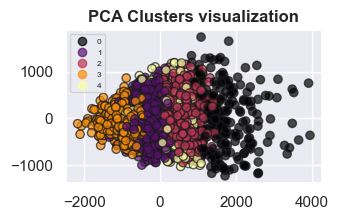

In [72]:
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap='inferno', edgecolor='k'
             , alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(km.labels_)),fontsize="6")
plt.title('PCA Clusters visualization')
plt.savefig(f"../images/ts_features_pca_syll.pdf")
plt.show()